2025-04-17 15:33:20.287220: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-17 15:33:20.317352: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-17 15:33:20.317385: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-17 15:33:20.317406: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 15:33:20.323434: I tensorflow/core/platform/cpu_feature_g


선택된 시나리오 인덱스: [65, 56, 44, 104, 84, 20, 101, 95, 1, 59]


2025-04-17 15:33:27.912433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-04-17 15:33:27.982630: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


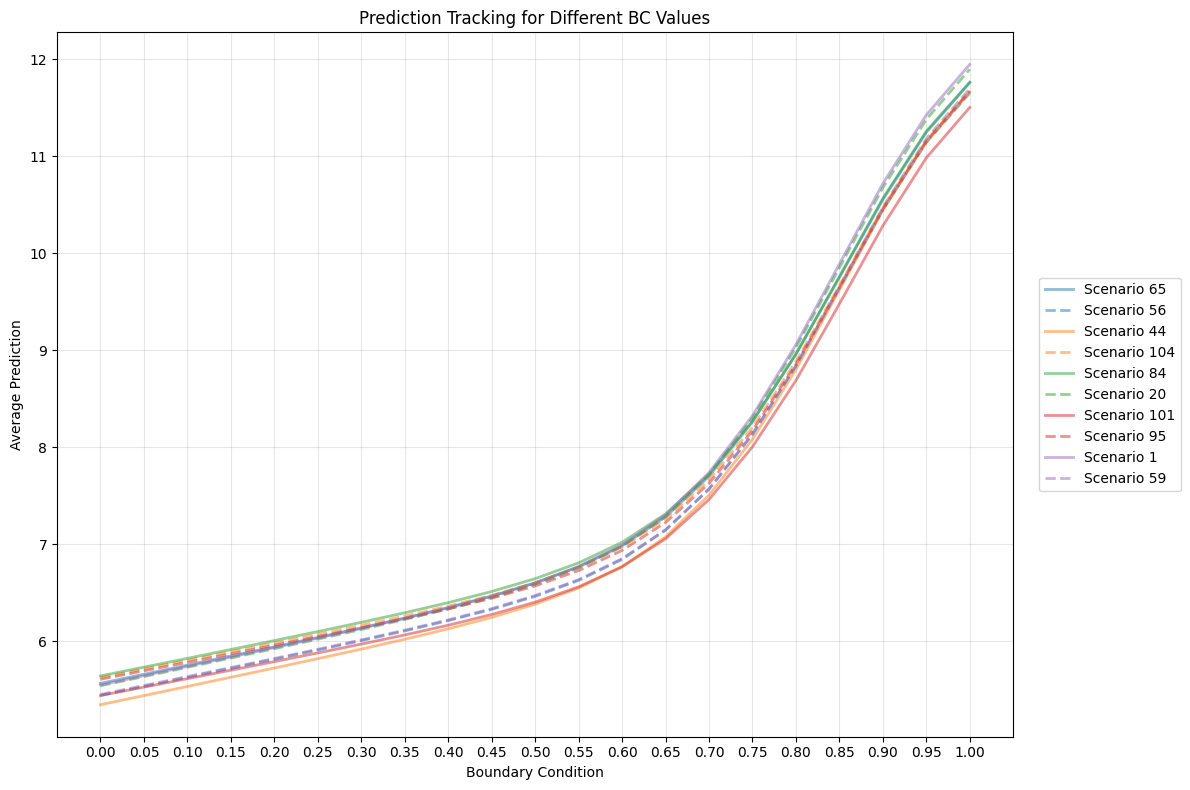

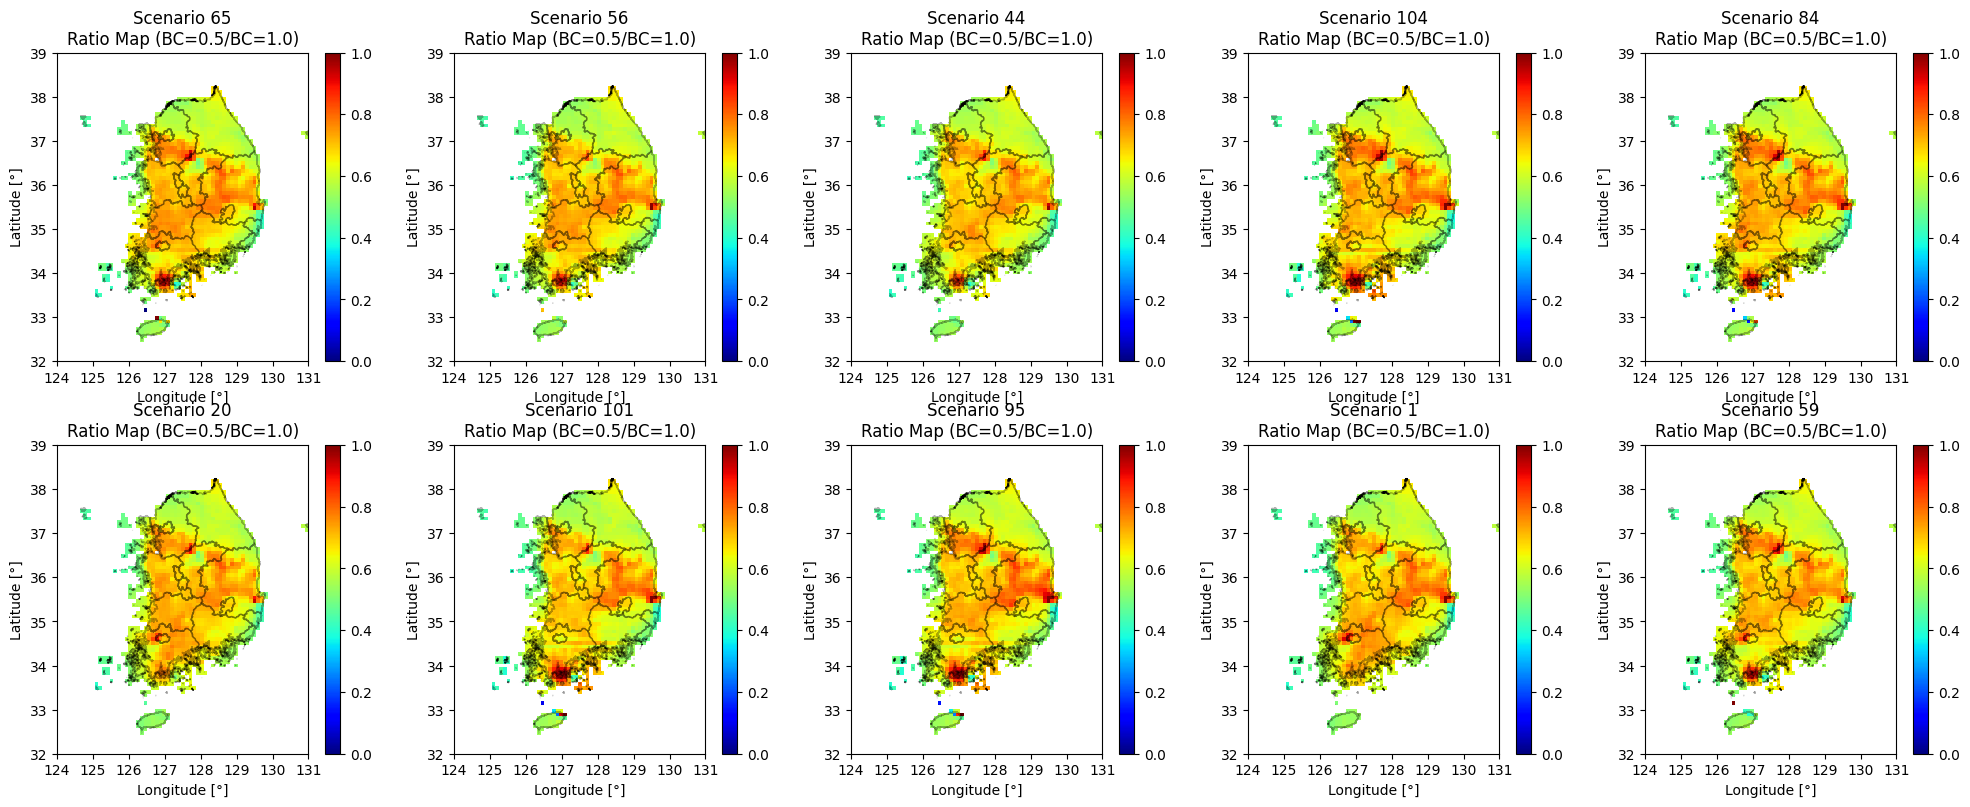

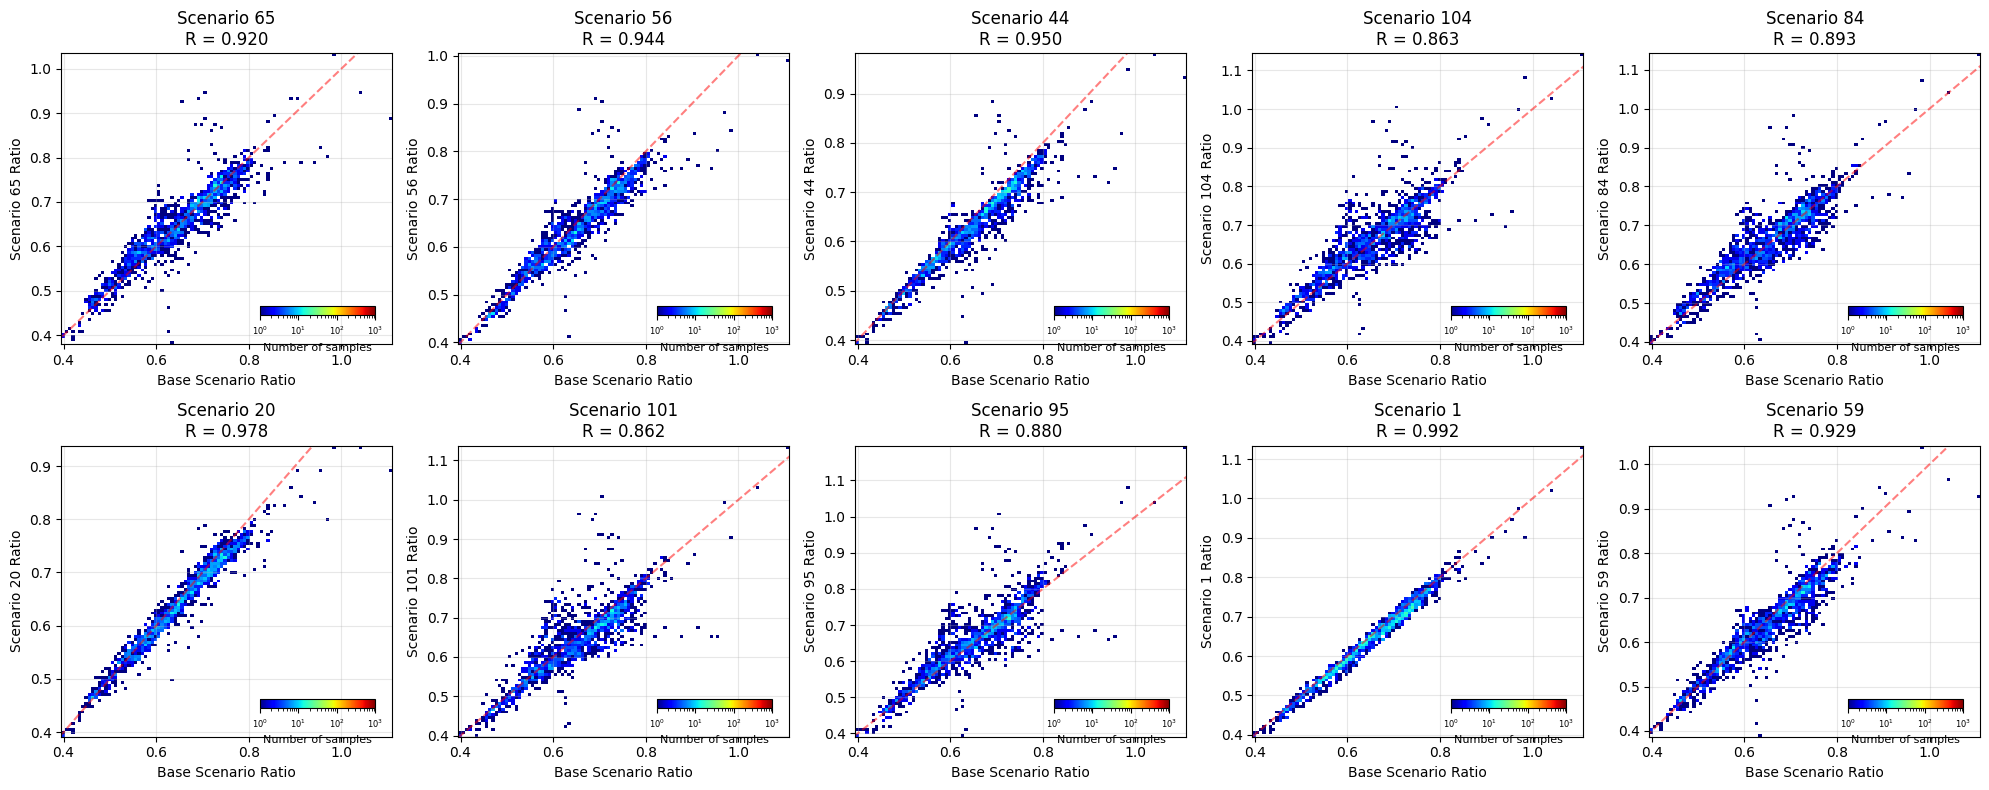

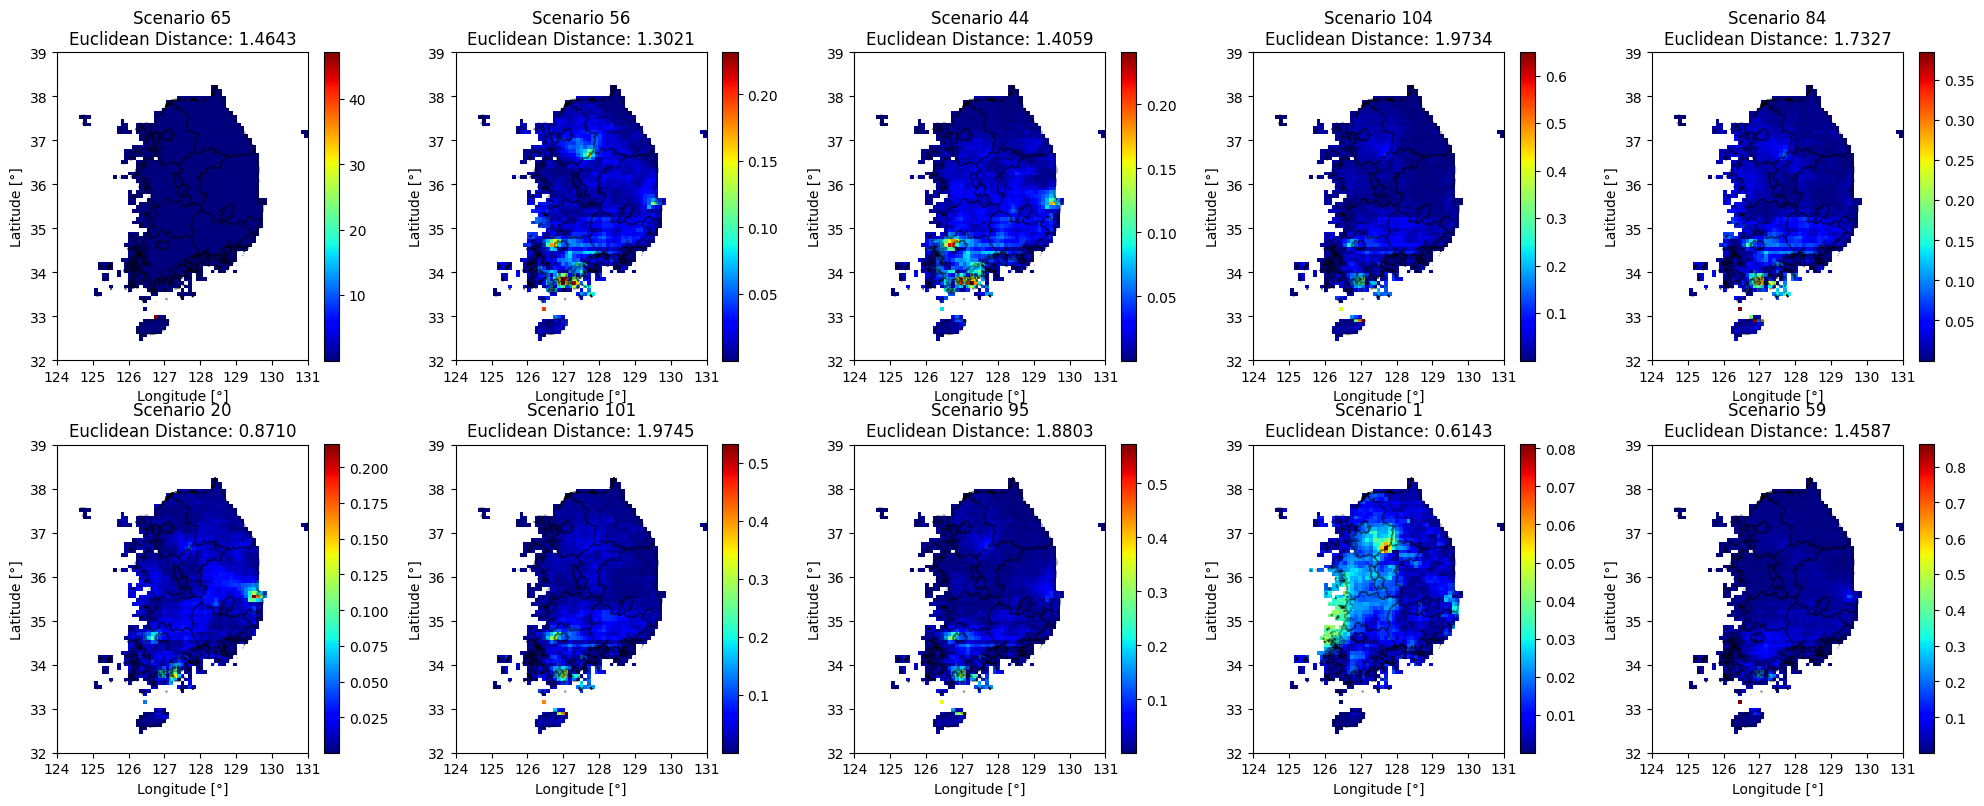

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import seaborn as sns
from matplotlib.gridspec import GridSpec
import random
import geopandas as gpd
from shapely.geometry import Point

# 좌표계 오프셋 설정 (Lambert Conformal Conic projection 기준)
offset_x = 171000  # 한반도 좌표계 오프셋 X
offset_y = 1735000  # 한반도 좌표계 오프셋 Y

# ============
# 행정구역 경계 데이터 로드
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/CMAQ_Emulator/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1
cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')
# ============

# GPU 메모리 성장 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 1. 모델 및 데이터 로드
def load_model_and_data():
    # 모델 로드
    model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/pm25_prediction/final_model_v2')
    # 입력 데이터셋 로드
    emis_ctrl = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2019_pm25.csv')
        
    return model, emis_ctrl

# 2. 유틸리티 함수들
def get_prediction_for_boundary(model, emis_control, boundary_value):
    """단일 시나리오에 대한 예측"""
    control_batch = np.expand_dims(emis_control, axis=0)            # (1, ctrl_dim)
    boundary_batch = np.expand_dims(np.array([boundary_value], dtype=np.float32), axis=0)  # (1, 1)
    pred = model.predict([control_batch, boundary_batch], verbose=0)
    return pred[0]

def compute_ratio_map(pred_map_low, pred_map_high, epsilon=1e-10):
    """Ratio map 계산"""
    return np.squeeze(pred_map_low / (pred_map_high + epsilon))

def apply_mask(data, mask):
    """마스크 적용하여 한국 영토 영역만 추출"""
    return data[mask == 1]

# 3. 시각화 함수들
def plot_bc_tracking(model, scenarios, scenario_indices, bc_values):
    """BC 값 변화에 따른 평균 예측값 추적"""
    plt.figure(figsize=(12, 8))
    
    # 색상 순서 지정 (파랑-주황-녹색-빨강-보라)
    colors = [
        '#1f77b4',  # 파랑
        '#1f77b4',  # 파랑
        '#ff7f0e',  # 주황
        '#ff7f0e',  # 주황
        '#2ca02c',  # 녹색
        '#2ca02c',  # 녹색
        '#d62728',  # 빨강
        '#d62728',  # 빨강
        '#9467bd',  # 보라
        '#9467bd'   # 보라
    ]
    
    # 선 스타일 지정 (실선-대시 반복)
    line_styles = ['-', '--'] * 5
    
    for (scenario, idx), color, line_style in zip(zip(scenarios, scenario_indices), colors, line_styles):
        predictions = []
        for bc in bc_values:
            pred = get_prediction_for_boundary(model, scenario, bc)
            predictions.append(np.mean(pred))
        
        plt.plot(bc_values, predictions, 
                linestyle=line_style,
                color=color, 
                linewidth=2,
                alpha=0.5,  # 투명도 증가
                label=f'Scenario {idx}')
    
    plt.xlabel('Boundary Condition')
    plt.ylabel('Average Prediction')
    plt.title('Prediction Tracking for Different BC Values')
    plt.grid(True, alpha=0.3)
    
    # x축 눈금 설정 (0.5부터 1.0까지 0.05 간격)
    # plt.xticks(np.arange(0.5, 1.05, 0.05))
    plt.xticks(np.arange(0.0, 1.05, 0.05))
    
    # 범례 위치 및 스타일 조정
    plt.legend(loc='center left', 
              bbox_to_anchor=(1.02, 0.5),
              ncol=1, 
              fontsize=10, 
              framealpha=0.8)
    
    plt.tight_layout()
    plt.savefig('Fig_1.png', dpi=300, bbox_inches='tight')
    plt.show()

# 2. plot_ratio_maps 함수 
def plot_ratio_maps(model, scenarios, scenario_indices, mask):
    """선택된 시나리오들의 Ratio Map"""

    cmap_with_white = plt.get_cmap('jet').copy()   # jet 컬러맵 복사
    cmap_with_white.set_bad('white')               # 마스킹된 부분을 흰색으로

    n_scenarios = len(scenarios)
    n_rows = 2
    n_cols = 5
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))
    axes = axes.flatten()
        
    # 좌표계 설정
    x_min = -180000 + offset_x
    x_max = 414000 + offset_x
    y_min = -585000 + offset_y
    y_max = 144000 + offset_y

    x_ticks = np.linspace(x_min, x_max, 8)
    x_labels = [str(i) for i in range(124, 132)]
    y_ticks = np.linspace(y_min, y_max, 8)
    y_labels = [str(i) for i in range(32, 40)]
    
    for idx, (ax, scenario, scenario_idx) in enumerate(zip(axes, scenarios, scenario_indices)):
        # Ratio map 계산
        pred_0_5 = get_prediction_for_boundary(model, scenario, 0.5)
        pred_1_0 = get_prediction_for_boundary(model, scenario, 1.0)
        ratio_map = compute_ratio_map(pred_0_5, pred_1_0)
        
        # 마스킹 처리 - grid_allocation 기반 마스킹 적용
        map_data = ratio_map[::-1]
        # 마스크 적용
        masked_map = np.where(mask == 1, map_data, np.nan)  # 마스크가 0인 부분을 NaN으로 설정
        
        # 지도 표시
        im = ax.imshow(
            masked_map[::-1],
            cmap=cmap_with_white,
            origin='upper',
            extent=(x_min, x_max, y_min, y_max),
            vmin=0, vmax=1  # ratio map의 범위는 0~1로 고정
        )
        # 행정구역 경계 표시
        ctprvn_proj.boundary.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1, alpha=0.3)
        # 축 설정
        ax.set_title(f"Scenario {scenario_idx}\nRatio Map (BC=0.5/BC=1.0)")
        ax.set_xlabel('Longitude [°]')
        ax.set_ylabel('Latitude [°]')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.set_xticklabels(x_labels)
        ax.set_yticklabels(y_labels)
        
        # 컬러바 추가
        plt.colorbar(im, ax=ax)
    
    # 남은 subplot 제거
    for idx in range(n_scenarios, n_rows * n_cols):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.savefig('Fig_2.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_scatter_comparison(model, base_scenario, scenarios, scenario_indices, mask):
    """기준 시나리오와 선택된 시나리오들의 Ratio Map Scatter Plot"""
    n_scenarios = len(scenarios)
    n_rows = 2
    n_cols = 5
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))  # 전체 figure 크기 조정
    axes = axes.flatten()  # 2D array를 1D로 변환
    
    # 기준 시나리오의 ratio map
    base_0_5 = get_prediction_for_boundary(model, base_scenario, 0.5)
    base_1_0 = get_prediction_for_boundary(model, base_scenario, 1.0)
    base_ratio = compute_ratio_map(base_0_5, base_1_0)
    base_masked = apply_mask(base_ratio, mask)
    
    for idx, (ax, scenario, scenario_idx) in enumerate(zip(axes, scenarios, scenario_indices)):
        pred_0_5 = get_prediction_for_boundary(model, scenario, 0.5)
        pred_1_0 = get_prediction_for_boundary(model, scenario, 1.0)
        ratio_map = compute_ratio_map(pred_0_5, pred_1_0)
        scenario_masked = apply_mask(ratio_map, mask)
        
        # Scatter plot with hist2d
        hist = ax.hist2d(base_masked, scenario_masked,
                        bins=100, cmap='jet', cmin=1,
                        norm=plt.matplotlib.colors.LogNorm(vmin=1, vmax=1000))
        
        # 상관계수 계산
        corr = stats.pearsonr(base_masked, scenario_masked)[0]
        
        # 대각선 그리기
        min_val = min(base_masked.min(), scenario_masked.min())
        max_val = max(base_masked.max(), scenario_masked.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
        
        ax.set_title(f'Scenario {scenario_idx}\nR = {corr:.3f}')
        ax.set_xlabel('Base Scenario Ratio')
        ax.set_ylabel(f'Scenario {scenario_idx} Ratio')
        ax.grid(True, alpha=0.3)
        
        # 각 subplot에 컬러바 추가
        cbaxes = ax.inset_axes([0.6, 0.1, 0.35, 0.03])
        cb = plt.colorbar(hist[3], cax=cbaxes, orientation='horizontal')
        cb.set_label('Number of samples', fontsize=8)
        cb.ax.tick_params(labelsize=6)
    
    # 남은 subplot 제거
    for idx in range(n_scenarios, n_rows * n_cols):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.savefig('Fig_3.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_absolute_ratio_difference_maps(model, base_scenario, selected_scenarios, selected_indices, mask):
    """
    Base 시나리오의 Ratio Map과 독립 시나리오들의 Ratio Map 간의 절대 차이를 시각화
    
    Args:
        model: 학습된 모델
        base_scenario: 기준이 되는 Base 시나리오
        selected_scenarios: 선택된 시나리오들의 리스트
        selected_indices: 선택된 시나리오들의 인덱스
        mask: 지역 마스크
    """
    cmap_with_white = plt.get_cmap('jet').copy()
    cmap_with_white.set_bad('white')

    # Base 시나리오의 ratio map 계산
    base_pred_05 = get_prediction_for_boundary(model, base_scenario, 0.5)
    base_pred_1 = get_prediction_for_boundary(model, base_scenario, 1.0)
    base_ratio = compute_ratio_map(base_pred_05, base_pred_1)

    n_scenarios = len(selected_scenarios)
    n_rows = 2
    n_cols = 5
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))
    axes = axes.flatten()

    # 좌표계 설정
    x_min = -180000 + offset_x
    x_max = 414000 + offset_x
    y_min = -585000 + offset_y
    y_max = 144000 + offset_y

    x_ticks = np.linspace(x_min, x_max, 8)
    x_labels = [str(i) for i in range(124, 132)]
    y_ticks = np.linspace(y_min, y_max, 8)
    y_labels = [str(i) for i in range(32, 40)]

    euclidean_distances = []

    for idx, (ax, scenario, scenario_idx) in enumerate(zip(axes, selected_scenarios, selected_indices)):
        # 현재 시나리오의 ratio map 계산
        pred_05 = get_prediction_for_boundary(model, scenario, 0.5)
        pred_1 = get_prediction_for_boundary(model, scenario, 1.0)
        scenario_ratio = compute_ratio_map(pred_05, pred_1)
        
        # Ratio map 간의 절대 차이 계산
        ratio_diff = np.abs(scenario_ratio - base_ratio)
        
        # Euclidean distance 계산 (마스크가 1인 영역에 대해서만)
        masked_diff = ratio_diff[mask == 1]
        euclidean_dist = np.sqrt(np.sum(masked_diff**2))
        euclidean_distances.append(euclidean_dist)
        
        # 마스킹 처리
        map_data = ratio_diff[::-1]
        masked_map = np.where(mask == 1, map_data, np.nan)
        
        # 지도 표시
        im = ax.imshow(
            masked_map[::-1],
            cmap=cmap_with_white,
            origin='upper',
            extent=(x_min, x_max, y_min, y_max)
        )
        
        # 행정구역 경계 표시
        ctprvn_proj.boundary.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1, alpha=0.3)
        
        # 축 설정
        ax.set_title(f"Scenario {scenario_idx}\nEuclidean Distance: {euclidean_dist:.4f}")
        ax.set_xlabel('Longitude [°]')
        ax.set_ylabel('Latitude [°]')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.set_xticklabels(x_labels)
        ax.set_yticklabels(y_labels)
        
        plt.colorbar(im, ax=ax)
    
    # 남은 subplot 제거
    for idx in range(n_scenarios, n_rows * n_cols):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.savefig('Fig_4.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Euclidean distance 결과 반환
    return pd.DataFrame({
        'Scenario_Index': selected_indices,
        'Euclidean_Distance': euclidean_distances
    })

def main():
    # 모델 및 데이터 로드
    model, emis_ctrl = load_model_and_data()
    # 시나리오 선택
    n_scenarios = 10
    total_scenarios = len(emis_ctrl)
    selected_indices = random.sample(range(total_scenarios), n_scenarios)
    print(f"\n선택된 시나리오 인덱스: {selected_indices}")
    # 선택된 시나리오의 데이터 추출
    selected_scenarios = [emis_ctrl.iloc[idx].values[:-1] for idx in selected_indices]  # 마지막 열(Boundary) 제외
    base_scenario = emis_ctrl.iloc[0].values[:-1]  # 첫 번째 행을 base scenario로 사용 (마지막 열 제외)
    # BC 값 범위 설정
    # bc_values = np.arange(0.5, 1.05, 0.05)
    bc_values = np.arange(0.0, 1.05, 0.05)
    '''1. BC tracking plot'''
    plot_bc_tracking(model, selected_scenarios, selected_indices, bc_values)
    '''2. Ratio maps'''
    plot_ratio_maps(model, selected_scenarios, selected_indices, mask)
    '''3. Scatter plots'''
    plot_scatter_comparison(model, base_scenario, selected_scenarios, selected_indices, mask)
    '''4. Absolute Ratio Difference Maps'''
    plot_absolute_ratio_difference_maps(model, base_scenario, selected_scenarios, selected_indices, mask)
    
if __name__ == "__main__":
    main()